## YOLACT
- [YOLACT: Real-time Instance Segmentation](https://arxiv.org/abs/1904.02689)
- [YOLACT++: Better Real-time Instance Segmentation](https://arxiv.org/abs/1912.06218)


## Custom Training
Based on: https://www.immersivelimit.com/tutorials/train-yolact-with-a-custom-coco-dataset

# Initial Setup
First, we install some Python libraries. Google Colab probably has these requirements already

## Libraries

In [ ]:
!pip install cython
!pip install opencv-python pillow pycocotools matplotlib

# Downgrade torch to accommodate DCNv2
!pip install torchvision==0.5.0
!pip install torch==1.4.0

#!pip install git+https://github.com/waleedka/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI

     |████████████████████████████████| 4.0MB 7.2MB/s 
     |████████████████████████████████| 753.4MB 22kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


## Unzip dataset uploaded on Drive
Formatted with Coco standard, only a few pictures to check if the algorithm is working.\
Creatted using Hyperlabel

In [ ]:
%cd /content
!unzip '/content/drive/MyDrive/Colab Notebooks/yolact/Teste_Coco.zip'

/content
Archive:  /content/drive/MyDrive/Colab Notebooks/yolact/Teste_Coco.zip
   creating: Teste_Coco_Instance/test/
  inflating: Teste_Coco_Instance/test/vid_220_frame_66_jpg.rf.e373bcc272560516a126deb6dbba3647.jpg  
  inflating: Teste_Coco_Instance/test/vid_5_frame_1218_jpg.rf.652620e2f20a5b33ef14c4d5e5747c07.jpg  
  inflating: Teste_Coco_Instance/test/vid_76_frame_204_jpg.rf.f6633c68f56c865260a82e5648fde911.jpg  
   creating: Teste_Coco_Instance/train/
  inflating: Teste_Coco_Instance/train/coco_annotations.json  
   creating: Teste_Coco_Instance/train/images/
  inflating: Teste_Coco_Instance/train/images/vid_2_frame_1708.jpg  
  inflating: Teste_Coco_Instance/train/images/vid_220_frame_3.jpg  
  inflating: Teste_Coco_Instance/train/images/vid_220_frame_4.jpg  
  inflating: Teste_Coco_Instance/train/images/vid_76_frame_172.jpg  
   creating: Teste_Coco_Instance/valid/
  inflating: Teste_Coco_Instance/valid/coco_annotations.json  
   creating: Teste_Coco_Instance/valid/images/
  in

## Clone YOLACT from GitHub

In [ ]:
%cd /content

# Clone the repo
!git clone https://github.com/dbolya/yolact.git

/content
Cloning into 'yolact'...
remote: Enumerating objects: 2936, done.
remote: Total 2936 (delta 0), reused 0 (delta 0), pack-reused 2936
Receiving objects: 100% (2936/2936), 21.20 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (2001/2001), done.


Now you have to open /yolact/data/config.py and find line 131, include the lines below: \

```python
cones_dataset = dataset_base.copy({ 
  'name': 'Formula SAE - Cones', 
  'train_info': '/content/Teste_Coco_Instance/train/coco_annotations.json', 
  'train_images': '/content/Teste_Coco_Instance/train/images/', 
  'valid_info': '/content/Teste_Coco_Instance/valid/coco_annotations.json', 
  'valid_images': '/content/Teste_Coco_Instance/valid/images/', 
  'class_names': ('0', '1', '2'), 
  'label_map': { 1:  1,  2:  2,  3:  3 } 
})
```


Change these path as you've built your dataset

Also in this file, add these lines some place around line 763:

```python
yolact_resnet50_cones_dataset_config = yolact_resnet50_config.copy({
    'name': 'yolact_plus_resnet50_cones_dataset',
    # Dataset stuff
    'dataset': cones_dataset,
    'num_classes': len(cones_dataset.class_names) + 1,

    # Image Size
    'max_size': 512,
})
```

And again in this file, change the 'path' in line 267 to be like this:

```python
resnet50_backbone = resnet101_backbone.copy({
    'name': 'ResNet50',
    'path': 'yolact_plus_resnet50_54_800000.pth',
    'type': ResNetBackbone,
    'args': ([3, 4, 6, 3],),
    'transform': resnet_transform,
})
```

We are changing the pre trained weights because the original (resnet50-19c8e357) wasn't working

## DCNv2
The DCNv2 external library is needed for this to work, so we'll build it now.

In [ ]:
# Change to the right directory
%cd /content/yolact/external/DCNv2

# Build DCNv2
!python setup.py build develop

/content/yolact/external/DCNv2
running build
running build_ext
building '_ext' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/content
creating build/temp.linux-x86_64-3.6/content/yolact
creating build/temp.linux-x86_64-3.6/content/yolact/external
creating build/temp.linux-x86_64-3.6/content/yolact/external/DCNv2
creating build/temp.linux-x86_64-3.6/content/yolact/external/DCNv2/src
creating build/temp.linux-x86_64-3.6/content/yolact/external/DCNv2/src/cpu
creating build/temp.linux-x86_64-3.6/content/yolact/external/DCNv2/src/cuda
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DWITH_CUDA -I/content/yolact/external/DCNv2/src -I/usr/local/lib/python3.6/dist-packages/torch/include -I/usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.6/dist-packages/torch/include/TH -I/usr/local/

## Pretrained Weights


In [ ]:
%cd /content

!git clone https://github.com/chentinghao/download_google_drive.git

!mkdir -p /content/yolact/weights

# Download file
!python ./download_google_drive/download_gdrive.py 1ZPu1YR2UzGHQD0o1rEqy-j5bmEm3lbyP ./yolact/weights/yolact_plus_resnet50_54_800000.pth
#!python ./download_google_drive/download_gdrive.py Jy3yCdbatgXa5YYIdTCRrSV0S9V5g1rn ./yolact/weights/resnet50-19c8e357.pth

/content
Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
129MB [00:00, 220MB/s]


#Training

batch_size is 1 because I only have 3 or 4 pictures, open ./yolact/train.py to see all the training parameters

In [ ]:
%cd /content/yolact
#!python train.py --config=yolact_base_config
!python train.py --config=yolact_resnet50_cones_dataset_config --batch_size=1

/content/yolact
Scaling parameters by 0.12 to account for a batch size of 1.
Per-GPU batch size is less than the recommended limit for batch norm. Disabling batch norm.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Initializing weights...
Begin training!

[  0]       0 || B: 5.523 | C: 5.815 | M: 7.789 | S: 2.021 | T: 21.149 || ETA: 100 days, 20:36:53 || timer: 1.362
[  2]      10 || B: 6.449 | C: 5.682 | M: 9.224 | S: 2.021 | T: 23.376 || ETA: 26 days, 16:12:00 || timer: 0.149

Computing validation mAP (this may take a while)...


Calculating mAP...

       |  all  |  .50  |  .55  |  .60  |  .65  |  .70  |  .75  |  .80  |  .85  |  .90  |  .95  |
-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
   box |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |
  mask |  0.00 |  0.00 |  0.00 

# Run Inference on Images
Let's run inference. We do that with eval.py, change the model to your file, it'll be save in ./yolact/weights

In [ ]:
%cd /content

!rm /content/output_images -r

# Create a new directory for output images
!mkdir -p /content/output_images

# Run inference using our pre-trained weights on all images in the directory
!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_cones_dataset_371_1486_interrupt.pth --config=yolact_resnet50_cones_dataset_config --score_threshold=0.15 --top_k=15 --images=/content/Teste_Coco_Instance/test:output_images

/content
Loading model... Done.

/content/Teste_Coco_Instance/test/vid_5_frame_1218_jpg.rf.652620e2f20a5b33ef14c4d5e5747c07.jpg -> output_images/vid_5_frame_1218_jpg.rf.652620e2f20a5b33ef14c4d5e5747c07.png
/content/Teste_Coco_Instance/test/vid_220_frame_66_jpg.rf.e373bcc272560516a126deb6dbba3647.jpg -> output_images/vid_220_frame_66_jpg.rf.e373bcc272560516a126deb6dbba3647.png
/content/Teste_Coco_Instance/test/vid_76_frame_204_jpg.rf.f6633c68f56c865260a82e5648fde911.jpg -> output_images/vid_76_frame_204_jpg.rf.f6633c68f56c865260a82e5648fde911.png
Done.


## Display Output Images
The last step saved output images, so we'll display those now.

output_images/vid_5_frame_1218_jpg.rf.652620e2f20a5b33ef14c4d5e5747c07.png


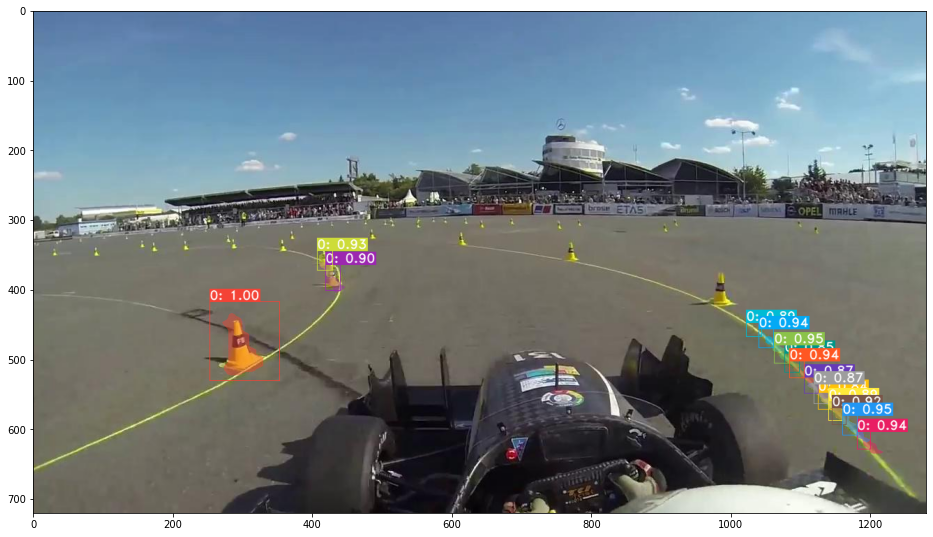

output_images/vid_220_frame_66_jpg.rf.e373bcc272560516a126deb6dbba3647.png


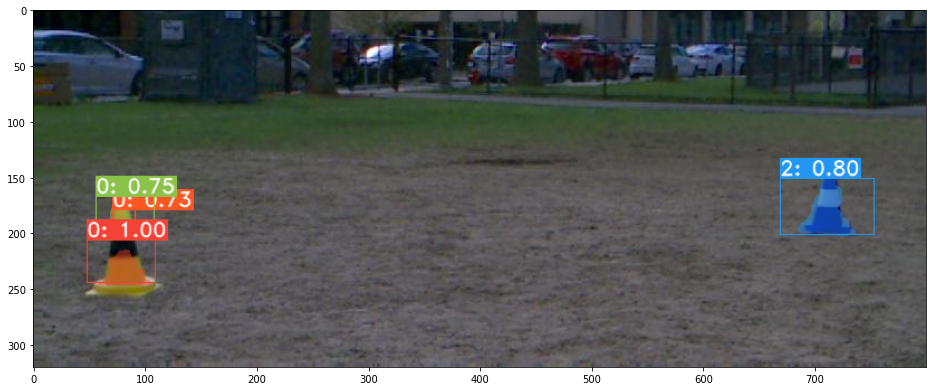

output_images/vid_76_frame_204_jpg.rf.f6633c68f56c865260a82e5648fde911.png


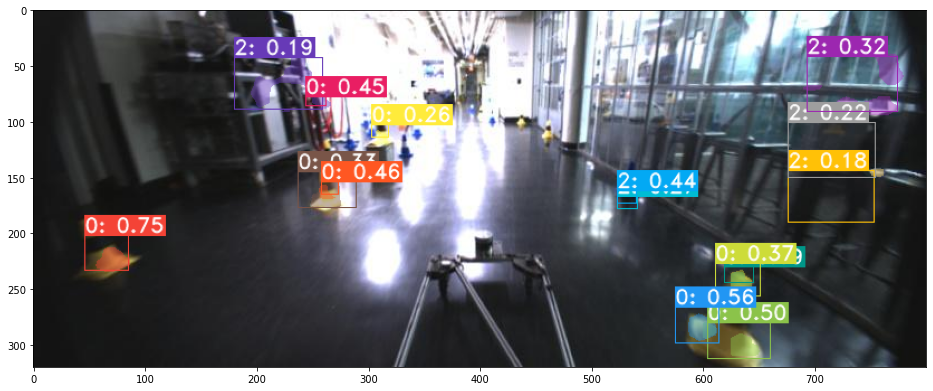

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

output_images = Path('output_images')

def show_image(img_path):
  img = cv2.imread(img_path)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(16,16))
  plt.imshow(img_cvt)
  plt.show()

# Iterate through all of the output images and display them
for img_path in output_images.iterdir():
  print(img_path)
  show_image(str(img_path))


## Example of video

In [ ]:
%cd /content
!mkdir -p /content/output_videos
output_path = "/content/output_videos/giraffes_full_720_output.mp4"
!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_54_800000.pth --score_threshold=0.15 --top_k=15 --video_multiframe=4 --video={file_path}:{output_path}

/content
Config not specified. Parsed yolact_plus_resnet50_config from the file name.

Loading model... Done.
Initializing model... Done.

Processing FPS: 13.68 | Video Playback FPS: 27.56 | Frames in Buffer: 0    Traceback (most recent call last):
  File "./yolact/eval.py", line 1104, in <module>
    evaluate(net, dataset)
  File "./yolact/eval.py", line 889, in evaluate
    evalvideo(net, inp, out)
  File "./yolact/eval.py", line 831, in evalvideo
    frame_buffer.put(frame['value'].get())
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 644, in get
    raise self._value
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "./yolact/eval.py", line 711, in prep_frame
    return prep_display(preds, frame, None, None, undo_transform=False, class_color=True, fps_str=fps_str)
  File "./yolact/eval.py", line 155, in prep_display
    idx = t[1].argsort(0, descending=True)[:args.top_k]
AttributeError: 'list' object 

### Download the output file


In [ ]:
!mkdir -p /content/drive/My\ Drive/YOLACT_output
%cd /content/drive/My\ Drive/YOLACT_output
!ls

/content/drive/My Drive/YOLACT_output


In [ ]:
!cp {output_path} /content/drive/My\ Drive/YOLACT_output/giraffes_full_720_output.mp4